# Notebook for analyzing Insider tradings and the effects on stock prices
Written by Thomas Niedermayer and Gunnar Sjúrðarson Knudsen, as a conjoined effort for an interdiscplinary project in Data Science.

Supervisor: Wolfgang Aussenegg

Co-Supervisor: Sascha Hunold

Purpose of this notebook is XXX

## Remaining todos:
* Create README.md and add a diagram of the project
* T1_ vs T1!!!
* A lot!
* Figure out which custom functions we are still using
* Figure out if different hypotheses should be tested based on "NAME" - or do both do all analysis?
* Refactor - we have data locations in two different varialbes (CAPS and preceeding underscore)
* I MIGHT have deleted too much from data_checks.run
* Currently have two different datasets for the ReturnIndex data - with (linear) interpolation, as well as skipping rows that don't exist in market and company.
* Figure out what to do, when event date not in the dataset. Could still "just" do closest possible, provided that trades occur around the date.
* What do we do when tickers are non-unique!? I think this is a nasty that breaks more than we know
* document get_all_directors_dealings_async
* Are outliers "Significant"? Wilcoxon compared to t-test

#### Ask Prof. Aussenegg
* Is it fair to compare like before pandemic with during pandemic? when there is an estimation window in the pre pandemic time and the event window is in the pandemic time
* Are we allowed to persist and upload the preprocessed data for this study?

### Hypotheses

#### Gunnar

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in the first
weeks after disclosure.
2. Hypothesis 2: Trades of type “Purchase” are most explaining of abnormal return.
“Sale” less so, and “Sale + Option” does not have an effect.
3. Hypothesis 3: Directors have changed behaviour during the times of Covid.

#### Tom

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in
the first weeks after disclosure of relevant information.
2. Hypothesis 2: Insiders are significantly good at avoiding risk indicated
by market downturns after insiders selling shares.
3. Hypothesis 3: Directors have changed behaviour during the times of
covid: Hypotheses 1 and 2 can be answered with significantly different
confidence before and during the pandemic.



## Setup

### Define which analysis is run
Add a name here. This affects which data is read in, as well as which analysis are done?

In [23]:
from tools import load_settings
settings = load_settings()
NAME = settings["NAME"]

### Load Libraries

In [24]:
# Standard libraries
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from scipy import stats


# custom functions
import source.analyse_single_company as UASC
from source import data_checks, determine_T0_T1_T2, cut_timeseries, calculate_coefficients
import logging

logging.getLogger().setLevel(logging.WARNING)

#plt.style.use("seaborn")

### Read in the data

In [25]:
# Data locations
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI_discard/'

# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

investigation_periods = {
    "overall": (pd.Timestamp("2018-01-01"), pd.Timestamp("2021-12-31")),
    "pre-pandemic": (pd.Timestamp("2018-01-01"), pd.Timestamp("2020-02-29")),
    "pandemic": (pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31")),
}

# Read in the summary data from "CompaniesToExclude" notebook
summary_data = pd.read_csv(DATA_LOCATION + '/scraping_summary.csv', index_col=0)
# Generate list of which companies to analyse
isins_to_use = summary_data[summary_data['reason_to_exclude'] == 'None']['ISIN CODE'].to_list()
display(summary_data)
print(f'We want to reduce to {len(isins_to_use)} isins')


## Not sure why we do this - maybe refactor
_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED

# Get locations to read in
file_locs_ = os.listdir(_ri_location)
print(f'Found {len(file_locs_)} possible files to analyze')
# Filter files for analysis, and append path:
file_locs = [_ri_location + f for f in file_locs_ if f[:-7] in isins_to_use]
print(f'We are left with {len(file_locs)} to analyze')

# Actually read in the company information
companies = []
print("loading return series...")
for file_loc in tqdm(file_locs):
    with open(file_loc, "rb") as f:
        company = pickle.load(f)
    companies.append(company)

,ISIN CODE,NAME,TICKER SYMBOL,trade_count,n_distinct_traders,n_distinct_trade_types,ts_rows,reason_to_exclude
764,US35953D1046,FUBOTV,FUBO,40,8,7,1509.0,Faulty timeseries data
954,US46124J2015,INVENTRUST PROPERTIES,IVT,4,4,1,1509.0,Faulty timeseries data
1939,NaN,ABOVENET 'B',ABVT,179,21,10,824.0,Missing ISIN
2093,NaN,ATHENA CONSUMER ACQUISITION CL B,ACAQ,1,1,1,824.0,Missing ISIN
2062,NaN,ARCTIC CAT 'B' DEAD - 07/03/17,ACAT,446,33,8,824.0,Missing ISIN
...,...,...,...,...,...,...,...,...
1057,US53228T1016,LIGHTNING EMOTORS,ZEV,16,13,5,430.0,None
3636,US98979J1097,ZOES KITCHEN DEAD - DELIST.21/11/18,ZOES,87,17,8,675.0,None
1923,US98978V1035,ZOETIS A,ZTS,499,34,8,1509.0,None
1926,US98983L1089,ZURN WATER SOLUTIONS,ZWS,526,27,8,1509.0,None


We want to reduce to 1534 isins
Found 2171 possible files to analyze
We are left with 1534 to analyze
loading return series...


100%|██████████| 1534/1534 [00:01<00:00, 1196.59it/s]


## Exploratory Data Analysis

### Calculate Returns, Analyse Companies

In [26]:
print("Returns")
returns_df = [c.return_index_df.company_return for c in companies]

print("concatenate")
df_returns = pd.concat(returns_df, axis=1)
df_return_index = pd.concat([c.return_index_df for c in companies], axis=1)


Returns
concatenate


### Visualise Mean Daily Returns

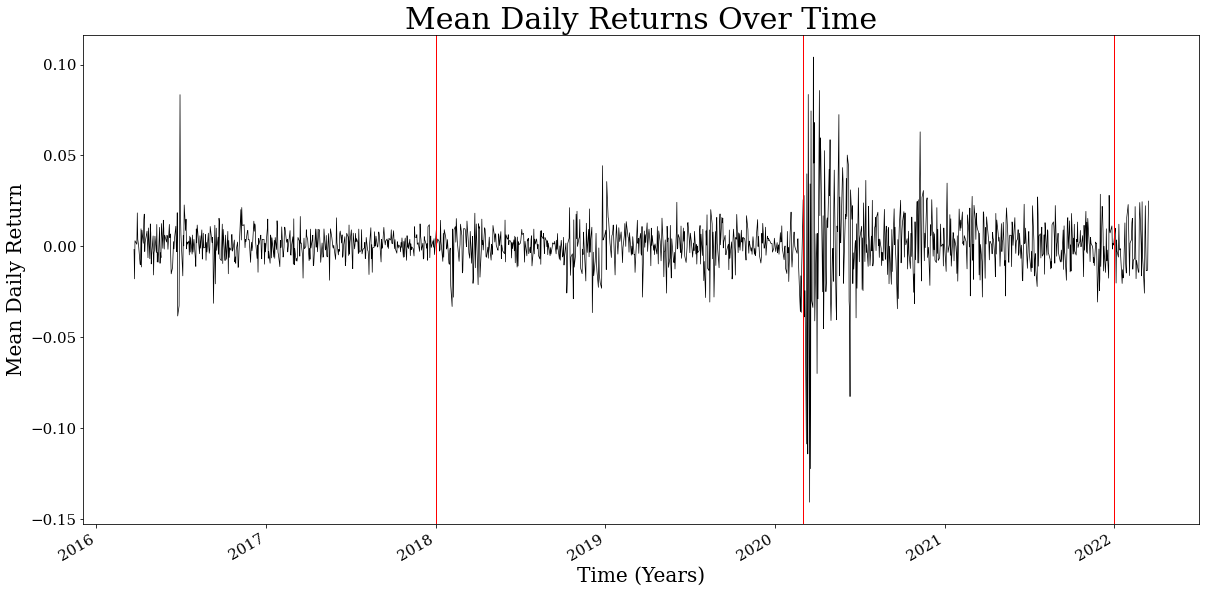

variance of the intervals
0.00009286120000000000
0.00051536910000000004


In [27]:
plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(fig_height, 10))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)', fontsize=label_size)
ax.set_ylabel('Mean Daily Return', fontsize=label_size)
ax.set_title('Mean Daily Returns Over Time', fontsize=title_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

interval_borders = ["2018-01-01", "2020-03-01", "2021-12-31"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.png", dpi=600, bbox_inches='tight')
plt.show()
# get var for the intervals
print("variance of the intervals")
print(f'{round(returns_companies.loc["2018-01-01":"2020-02-29"].var(),10):.20f}')
print(f'{round(returns_companies.loc["2020-03-01":"2021-12-31"].var(), 10):.20f}')


### Remove companies outside of the timeframe of interest

In [28]:
# this is the interval where filings are interesting to us
earliest_timestamp = list(investigation_periods.values())[0][0]
latest_timestamp = list(investigation_periods.values())[-1][1]
filings_removed = 0
filings_total = 0

for company in tqdm(companies):
    insider_data_df = company.insider_data_df
    filing_dates = insider_data_df.FilingDate.apply(lambda x: x.floor("d"))
    mask = (filing_dates >= earliest_timestamp) & (filing_dates <= latest_timestamp)
    company.insider_data_df = company.insider_data_df[mask]
    filings_removed += (~mask).sum()
    filings_total += mask.shape[0]

print("Total filings: {}".format(filings_total))
print("Removed {} filings".format(filings_removed))
print("Remaining filings: {}".format(filings_total - filings_removed))

100%|██████████| 1534/1534 [00:25<00:00, 59.48it/s]

Total filings: 1098006
Removed 807342 filings
Remaining filings: 290664


### Investigate Filing Trade Lag Times

In [29]:
print("get filing lags ...")

lags = []
for company in tqdm(companies):
    lag = UASC.analyse_single_company(company)
    lags.append(lag)


get filing lags ...


100%|██████████| 1534/1534 [00:37<00:00, 40.42it/s]


Negative lag for 10 out of 290664 trades.
Lag longer than 21 days for 5701 out of 290664 trades.
Eligible trades: 284953 out of 290664 trades.


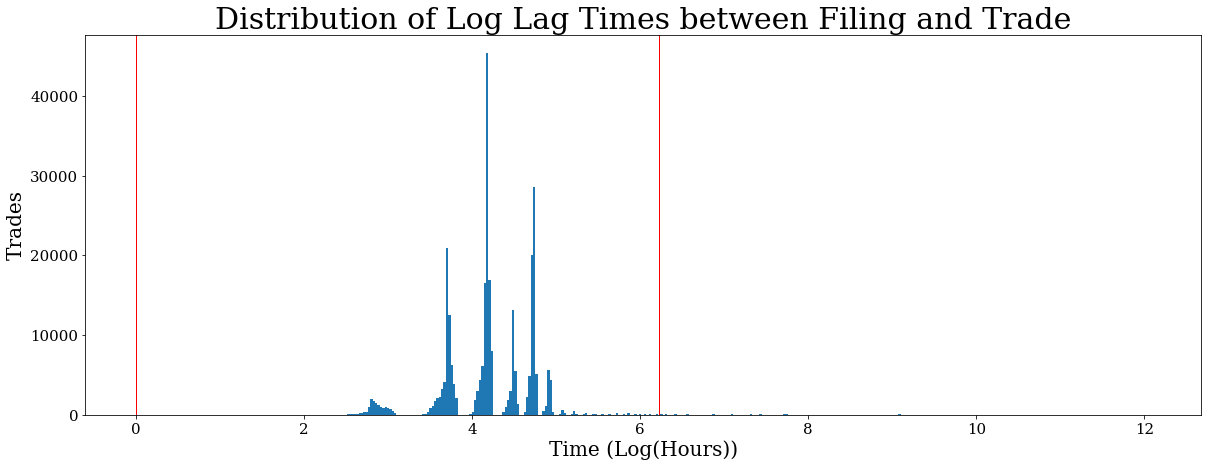

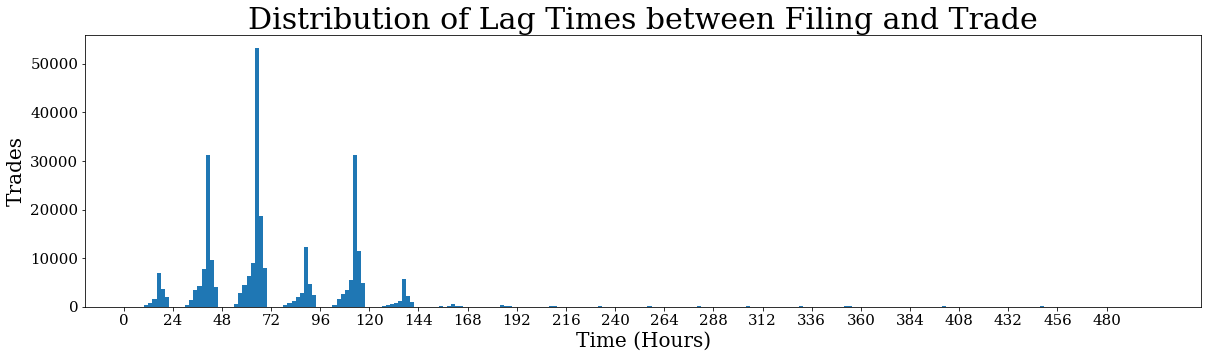

In [30]:
filing_trade_lags = sum(lags, [])

lag_in_hours = np.asarray(filing_trade_lags)
negative_lag_mask = lag_in_hours < 0
positive_lag = lag_in_hours[~negative_lag_mask]
in_21_days = positive_lag < 21*24
relevant_lag = positive_lag[in_21_days]
print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
print(f"Lag longer than 21 days for {len(positive_lag) - len(relevant_lag)} out of {len(negative_lag_mask)} trades.")
print(f"Eligible trades: {len(relevant_lag)} out of {len(negative_lag_mask)} trades.")

fig = plt.figure(figsize=(fig_height, 7))
ax = fig.add_subplot(1, 1, 1)
plt.hist(np.log(positive_lag), bins="auto")
ax.set_xlabel('Time (Log(Hours))', fontsize=label_size)
ax.set_ylabel('Trades', fontsize=label_size)
ax.set_title('Distribution of Log Lag Times between Filing and Trade', fontsize=title_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.axvline(x = 0, color = 'red', label = 'Zero', linewidth = 1)
plt.axvline(x = np.log(21*24), color = 'red', label = 'Threshold', linewidth = 1)
plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.png", dpi=600, bbox_inches='tight')
plt.show()

without_outliers = positive_lag[positive_lag < 24*21]

fig = plt.figure(figsize=(fig_height, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(without_outliers, bins="auto")
plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
ax.set_xlabel('Time (Hours)', fontsize=label_size)
ax.set_ylabel('Trades', fontsize=label_size)
ax.set_title('Distribution of Lag Times between Filing and Trade', fontsize=title_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.png", dpi=600, bbox_inches='tight')
plt.show()

### Drop companies with lags longer than 21 days or negative lags

In [31]:
removed_lags = 0
remaining_lags = 0

for lags_c, company in tqdm(zip(lags, companies)):
    lags_c = np.asarray(lags_c)
    mask_eligible = (lags_c >= 0) & (lags_c <= 21*24)
    company.insider_data_df = company.insider_data_df[mask_eligible]
    removed_lags += (~mask_eligible).sum()
    remaining_lags += mask_eligible.sum()

print(f"Total trades: {removed_lags + remaining_lags}")
print(f"Removed {removed_lags} trades.")
print(f"Remaining {remaining_lags} trades.")


1534it [00:00, 2996.10it/s]

Total trades: 290664
Removed 5711 trades.
Remaining 284953 trades.


## Demonstrate process for a single event

### Define windows

#### Our data contains multiple companies. A single company contains multiple filings and each filing is an event

![alt text](assets/images/windows.png "Title")

In [32]:
## Constants defining how long both Estimation Window and Event Window are
### Probably also input parameters to a function call, as we need loops later...
L1_length = 100
L2_length = 40 # TODO +-20 days = 40 days, right?

### Fix a company

In [33]:
logging.getLogger().setLevel(logging.DEBUG)

if NAME == "Knudsen":
    company_index = -87
elif NAME == "Niedermayer":
    company_index = -11
else:
    raise NotImplementedError
company = companies[company_index]
print(company)
company_return = company.return_index_df

Company(company_type='2634JX', isin='US98850P1093', name='YUM CHINA HOLDINGS', ticker='YUMC', start_date=Timestamp('2016-10-17 00:00:00'), end_date=datetime.datetime(2022, 3, 16, 0, 0), return_index_df=            ReturnIndex  company_return  market_return
Date                                                  
2016-10-17       100.00             NaN            NaN
2016-10-18        95.28       -0.047200       0.007144
2016-10-19        94.58       -0.007347       0.003363
2016-10-20        94.54       -0.000423      -0.001035
2016-10-21        97.15        0.027607      -0.001637
...                 ...             ...            ...
2022-03-10       180.06       -0.109407      -0.002618
2022-03-11       152.13       -0.155115      -0.010972
2022-03-14       148.36       -0.024781      -0.003525
2022-03-15       160.62        0.082637       0.012860
2022-03-16       175.84        0.094758       0.023172

[1363 rows x 3 columns], insider_data_df=     X          FilingDate  TradeDate Tic

### Fix an event

In [34]:
# This date will be moved to a loop
## Define which periods we are looking at.

if NAME == "Knudsen":
    event_index = 60
elif NAME == "Niedermayer":
    event_index = -200
else:
    raise NotImplementedError
    
event_timestamp = company.insider_data_df.FilingDate.iloc[event_index].floor("d")
print("event timestamp: ", event_timestamp)

event timestamp:  2021-02-11 00:00:00


### Technical Checks

In [35]:
data_checks.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

In [36]:
#company_return

### Determine T0, T1 and T2

In [37]:
T0_, T1_, T2_, T0, T1, T2, ERROR, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

DEBUG:root:Found T1 to be 2021-01-13 00:00:00 on index 1067
DEBUG:root:Found T2 to be 2021-03-12 00:00:00 on index 1107
DEBUG:root:Found T0 to be 2020-08-20 00:00:00 on index 967
DEBUG:root:------------------------------
DEBUG:root:Event occurred at             2021-02-11 00:00:00
DEBUG:root:Estimation Window (100 days): from 2020-08-20 00:00:00 to 2021-01-13 00:00:00
DEBUG:root:Event Window      ( 40 days): from 2021-01-13 00:00:00 to 2021-03-12 00:00:00


In [38]:
print(event_timestamp)
company_return

2021-02-11 00:00:00


,ReturnIndex,company_return,market_return
Date,,,
2016-10-17,100.00,NaN,NaN
2016-10-18,95.28,-0.047200,0.007144
2016-10-19,94.58,-0.007347,0.003363
2016-10-20,94.54,-0.000423,-0.001035
2016-10-21,97.15,0.027607,-0.001637
...,...,...,...
2022-03-10,180.06,-0.109407,-0.002618
2022-03-11,152.13,-0.155115,-0.010972
2022-03-14,148.36,-0.024781,-0.003525


### Abnormal and Normal Returns

![alt text](assets/images/return_estimation.png "Title")

### Cut return timeseries into correct periods

In [39]:
windows = cut_timeseries.run(company_return, T0, T1, T2)
estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows

DEBUG:root:shapes (Shouldnt be an issue after better preprocessing)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# event_window_market_return: (41,)
DEBUG:root:# event_window_company_return: (41,)


### Calculate coefficients

In [40]:
alpha, beta, eps = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

### The Abnormal Return
This is the last step of the whole process for one event

In [41]:
company_return = event_window_company_return
market_return = event_window_market_return
estimated_return = alpha + beta*market_return
abnormal_return = company_return - estimated_return
print(abnormal_return)

Date
2021-01-13    0.005718
2021-01-14   -0.018527
2021-01-15    0.002623
2021-01-19    0.032845
2021-01-20   -0.009413
2021-01-21    0.009074
2021-01-22   -0.005926
2021-01-25   -0.004569
2021-01-26    0.020685
2021-01-27   -0.000869
2021-01-28   -0.027442
2021-01-29    0.009520
2021-02-01    0.008587
2021-02-02    0.003729
2021-02-03   -0.024062
2021-02-04   -0.029404
2021-02-05    0.020774
2021-02-08    0.031924
2021-02-09    0.022931
2021-02-10   -0.010180
2021-02-11    0.019804
2021-02-12    0.010355
2021-02-16    0.025829
2021-02-17   -0.001085
2021-02-18   -0.007593
2021-02-19   -0.014930
2021-02-22   -0.015332
2021-02-23   -0.022877
2021-02-24   -0.005192
2021-02-25    0.014318
2021-02-26    0.005187
2021-03-01   -0.016050
2021-03-02   -0.003749
2021-03-03    0.009561
2021-03-04    0.005120
2021-03-05    0.006055
2021-03-08    0.007733
2021-03-09    0.004545
2021-03-10   -0.020795
2021-03-11    0.010672
2021-03-12   -0.010652
dtype: float64


<AxesSubplot:xlabel='Date'>

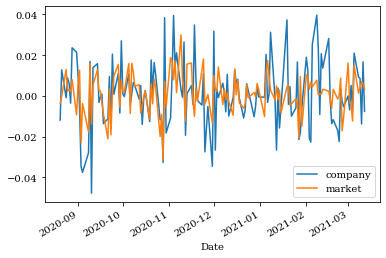

In [42]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

company_and_estimated = pd.DataFrame({"company":event_window_company_return, "market":estimated_return})
company_and_market = pd.DataFrame({"company": estimation_window_company_return, "market":estimation_window_market_return})
df_to_plot = pd.concat([company_and_market, company_and_estimated])
df_to_plot.plot()

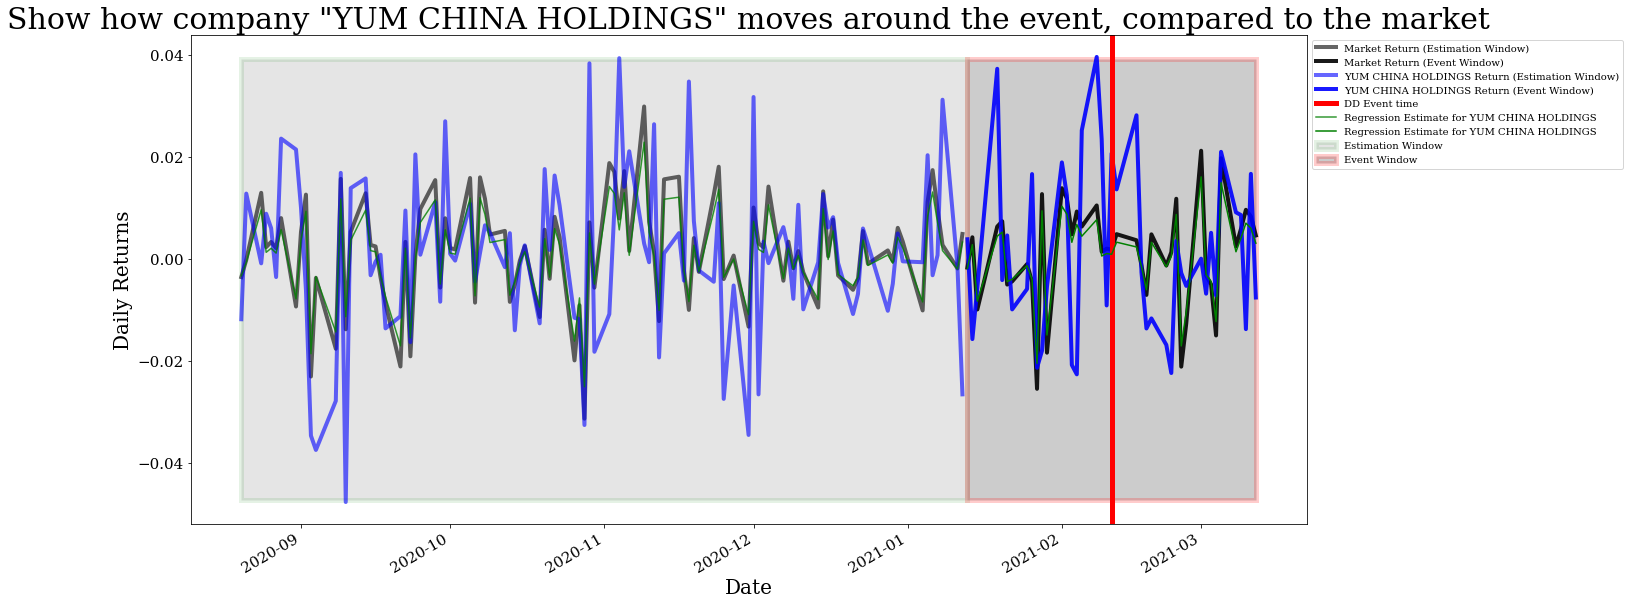

I'm impressed! It looks like a five-year-old drew this plot in paint


In [43]:
Company_name = company.name

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha

plt.figure(figsize=(fig_height,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns', fontsize=label_size)
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)

plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title(f'Show how company "{Company_name}" moves around the event, compared to the market', fontsize = title_size)
plt.xlabel('Date', fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.show()
print("I'm impressed! It looks like a five-year-old drew this plot in paint")


## Macro Analysis

### Now that we have seen the process for one single filing, let us do the same for all filings in all companies


In [44]:
# Initialize testing
logging.getLogger().setLevel(logging.ERROR)
# Helpers
multiind, data, data_errors = [], [], []
estimation_window_market_return_list, event_window_market_return_list, eps_list = [], [], []
n_companies = len(companies)


#for j in tqdm(range(len(companies[:200]))):
for j in tqdm(range(len(companies))):
    # Get information from said company
    company = companies[j]
    company_return = company.return_index_df
    
    n_filings = len(company.insider_data_df)
    # Go through all filings
    for i in company.insider_data_df.FilingDate.index:

        # Find our event date from filing
        filing_date = company.insider_data_df.FilingDate[i]
        event_timestamp = filing_date.floor("d")

        checks = data_checks.run(L1_length, L2_length, event_timestamp, company_return)
        if checks:
            #print(checks[1])
            data_errors.append(checks[0])
            continue
   
        ## Proceed to find periods
        T0_, T1_, T2_, T0, T1, T2, ERRORS, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)
        if ERRORS:
            #print(msg)
            data_errors.append(ERRORS)
            continue
            
        ## Cut timeseries to the relevant periods, and split them
        windows = cut_timeseries.run(company_return, T0, T1, T2)
        estimation_window_market_return, estimation_window_company_return,event_window_market_return, event_window_company_return = windows
        alpha, beta, eps = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return) # TODO change back to calculate_coefficients.run or check validity
        ## Calculate the abnormal returns
        abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
        
        ## Append to results
        estimation_window_market_return_list.append(estimation_window_market_return)
        event_window_market_return_list.append(event_window_market_return)
        eps_list.append(eps)
        multiind.append((company.ticker, i, company.insider_data_df.TradeType[i], event_timestamp))
        data.append(abnormal_return)

100%|██████████| 1534/1534 [06:58<00:00,  3.67it/s]


In [45]:
# process and save abnormal returns
df_abnormal_returns = pd.DataFrame.from_records([d.reset_index(drop=True) for d in data])
df_abnormal_returns.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

In [46]:
df_abnormal_returns

0         1         2   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.014430  0.020116  0.004401   
        60  A - Grant   2021-12-21       0.014430  0.020116  0.004401   
        61  S - Sale    2021-12-09      -0.028634 -0.001693 -0.010781   
        62  F - Tax     2021-12-03       0.011301  0.001713  0.015107   
        63  M - OptEx   2021-12-03       0.011301  0.001713  0.015107   
...                                           ...       ...       ...   
CPRI    202 S - Sale+OE 2018-03-05       0.006878  0.013922  0.005537   
        203 S - Sale+OE 2018-02-20      -0.011661  0.015493 -0.001020   
        204 S - Sale+OE 2018-02-15       0.004982  0.004987 -0.011666   
        205 M - OptEx   2018-02-15       0.004982  0.004987 -0.011666   
        206 S - Sale+OE 2018-02-15       0.004982  0.004987 -0.011666   

                                               3         4         5   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.003527 -0.009079  0.023717   
        60  A - Grant   2021-12-21       0.003527 -0.009079  0.023717   
        61  S - Sale    2021-12-09       0.000994  0.003367 -0.009981   
        62  F - Tax     2021-12-03      -0.000668 -0.028231 -0.001371   
        63  M - OptEx   2021-12-03      -0.000668 -0.028231 -0.001371   
...                                           ...       ...       ...   
CPRI    202 S - Sale+OE 2018-03-05       0.010974 -0.065314 -0.017620   
        203 S - Sale+OE 2018-02-20      -0.007168  0.004650 -0.009687   
        204 S - Sale+OE 2018-02-15       0.015538 -0.000993 -0.007123   
        205 M - OptEx   2018-02-15       0.015538 -0.000993 -0.007123   
        206 S - Sale+OE 2018-02-15       0.015538 -0.000993 -0.007123   

                                               6         7         8   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.017184 -0.016345  0.016463   
        60  A - Grant   2021-12-21       0.017184 -0.016345  0.016463   
        61  S - Sale    2021-12-09       0.004203 -0.036667  0.013896   
        62  F - Tax     2021-12-03      -0.010495  0.001344  0.003696   
        63  M - OptEx   2021-12-03      -0.010495  0.001344  0.003696   
...                                           ...       ...       ...   
CPRI    202 S - Sale+OE 2018-03-05       0.003245  0.019906 -0.000200   
        203 S - Sale+OE 2018-02-20       0.002418 -0.016642 -0.005571   
        204 S - Sale+OE 2018-02-15       0.004622 -0.009572  0.002556   
        205 M - OptEx   2018-02-15       0.004622 -0.009572  0.002556   
        206 S - Sale+OE 2018-02-15       0.004622 -0.009572  0.002556   

                                               9   ...        31        32  \
Company i   TradeType   event_timestamp            ...                       
SLB     59  A - Grant   2021-12-21      -0.007756  ...  0.018641  0.027985   
        60  A - Grant   2021-12-21      -0.007756  ...  0.018641  0.027985   
        61  S - Sale    2021-12-09       0.019698  ... -0.014686  0.010572   
        62  F - Tax     2021-12-03      -0.009565  ...  0.015467 -0.007739   
        63  M - OptEx   2021-12-03      -0.009565  ...  0.015467 -0.007739   
...                                           ...  ...       ...       ...   
CPRI    202 S - Sale+OE 2018-03-05       0.009355  ...  0.010019  0.004871   
        203 S - Sale+OE 2018-02-20       0.006751  ... -0.008953 -0.021966   
        204 S - Sale+OE 2018-02-15      -0.016590  ... -0.011653 -0.003920   
        205 M - OptEx   2018-02-15      -0.016590  ... -0.011653 -0.003920   
        206 S - Sale+OE 2018-02-15      -0.016590  ... -0.011653 -0.003920   

                                               33        34        35  \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21  

In [47]:
df_estimation_window_market_return = pd.DataFrame.from_records([d.reset_index(drop=True) for d in estimation_window_market_return_list])
df_estimation_window_market_return.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

In [48]:
df_event_window_market_return = pd.DataFrame.from_records([d.reset_index(drop=True) for d in event_window_market_return_list])
df_event_window_market_return.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

In [49]:
df_eps = pd.DataFrame.from_records([d.reset_index(drop=True) for d in eps_list])
df_eps.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])

### Show the reasons filings were dropped

In [50]:
errors_df = pd.DataFrame.from_records(data_errors)
errors_agg = errors_df.sum(axis=0)

In [51]:
# add earlier filtering
errors_agg["event not in overall time frame"] = filings_removed
errors_agg["negative lags"] = negative_lag_mask.sum()
errors_agg["more than 21 days lag"] = len(positive_lag) - len(relevant_lag)

In [52]:
errors_agg = pd.DataFrame(errors_agg)
errors_agg.index.name = "Reason"
errors_agg.columns = ["Count"]

In [53]:
print(errors_agg.astype(int).reset_index().to_latex(index=False))

\begin{tabular}{lr}
\toprule
                                        Reason &  Count \\
\midrule
event\_timestamp not in the company return data &    886 \\
    Don't have enough trading days after event &    961 \\
  Not enough days before event in company data &   2906 \\
               event not in overall time frame & 807342 \\
                                 negative lags &     10 \\
                         more than 21 days lag &   5701 \\
\bottomrule
\end{tabular}



C:\Users\Tom\AppData\Local\Temp\ipykernel_24932\1687419587.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(errors_agg.astype(int).reset_index().to_latex(index=False))


In [54]:
print(errors_agg.sum())

Count    817806.0
dtype: float64


In [55]:
df_abnormal_returns.to_pickle(f"data/{NAME}/calculate_AR_results/df_abnormal_returns.pkl")
df_estimation_window_market_return.to_pickle(f"data/{NAME}/calculate_AR_results/df_estimation_window_market_return.pkl")
df_event_window_market_return.to_pickle(f"data/{NAME}/calculate_AR_results/df_event_window_market_return.pkl")
df_eps.to_pickle(f"data/{NAME}/calculate_AR_results/df_eps.pkl")

with open(f"data/{NAME}/calculate_AR_results/companies.pkl", "wb") as f:
    pickle.dump(companies, f)